In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics



# Data Processing

In [2]:
# Specify File Location
# I use the full datafile from https://www.kaggle.com/code/u6yuvi/dog-vs-cat-classification-using-pytorch/data
data_dir = "/home/majd/ISC637_HW2/full_data/"


# Transform the data into tensors with same size and a normalized range of [-1, 1]
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


dataset = datasets.ImageFolder(root = data_dir, transform = transform)

# Split into train, test, and validation datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))


# Class labels
classes = ('cat', 'dog')


In [3]:
batch_size = 128

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 224, 224])
Shape of y: torch.Size([128]) torch.int64


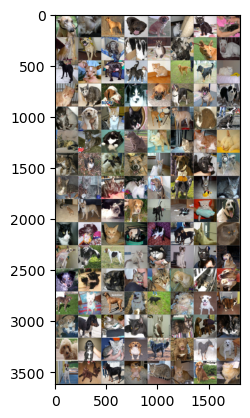

dog   dog   dog   dog   dog   cat   cat   cat   cat   dog   dog   cat   cat   cat   dog   dog   dog   dog   dog   cat   cat   dog   dog   cat   cat   cat   dog   cat   dog   dog   dog   dog   cat   dog   cat   cat   dog   dog   cat   dog   cat   dog   cat   cat   cat   cat   cat   cat   cat   cat   dog   dog   cat   dog   cat   dog   cat   cat   cat   cat   dog   dog   cat   cat   cat   dog   cat   dog   dog   cat   cat   dog   cat   cat   cat   dog   cat   dog   cat   cat   dog   dog   dog   cat   dog   cat   cat   dog   dog   cat   cat   cat   cat   dog   cat   dog   dog   dog   dog   dog   dog   dog   dog   cat   dog   dog   cat   cat   cat   cat   dog   cat   dog   dog   cat   dog   dog   dog   dog   dog   dog   cat   dog   dog   cat   cat   dog   cat  


In [4]:
# Show a batch of images as a sanity check

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define convnet architecture

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 150, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(150, 120, 4)
        self.conv3 = nn.Conv2d(120, 100, 5)
        self.conv4 = nn.Conv2d(100, 80, 6)
        self.conv5 = nn.Conv2d(80, 40, 6)
        self.fc1 = nn.Linear(40 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = NeuralNetwork().to(device)

# Print a nicer model summary
summary(model, (3, 224, 224))

Using cuda device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 150, 222, 222]           4,200
         MaxPool2d-2        [-1, 150, 111, 111]               0
            Conv2d-3        [-1, 120, 108, 108]         288,120
         MaxPool2d-4          [-1, 120, 54, 54]               0
            Conv2d-5          [-1, 100, 50, 50]         300,100
         MaxPool2d-6          [-1, 100, 25, 25]               0
            Conv2d-7           [-1, 80, 20, 20]         288,080
         MaxPool2d-8           [-1, 80, 10, 10]               0
            Conv2d-9             [-1, 40, 5, 5]         115,240
           Linear-10                  [-1, 120]         120,120
           Linear-11                   [-1, 60]           7,260
           Linear-12                    [-1, 1]              61
Total params: 1,123,181
Trainable params: 1,123,181
Non-trainable params: 0
---------

# Training the model

In [6]:
# Specify loss functon and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(),lr=0.001)

In [7]:
# Define transformation that will only be applied to the training data
# This effectively increases the size of the training set which helps avoid overfitting
train_transforms = transforms.Compose(
    [transforms.RandomRotation(20),
     transforms.RandomHorizontalFlip()])

# Define training epoch
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        
        X = train_transforms(X)
        
        # Reshape Labels and convert to float
        y = torch.reshape(y,(len(y),1))
        y = y.to(torch.float32)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()        

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Current batch training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss /= num_batches
    print(f"Training loss: {train_loss:>7f}")
    return(train_loss)

In [8]:
# Define test epoch loop
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Reshape Labels and convert to float
            y = torch.reshape(y,(len(y),1))
            y = y.to(torch.float32)
                        
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    print(f"Validation loss: {test_loss:>7f} \n")
    return(test_loss)


In [9]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 3

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, train(train_dataloader, model, loss_fn, optimizer))
    Validation_losses = np.append(Validation_losses,validate(val_dataloader, model, loss_fn))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: 0.693701  [    0/15000]
Current batch training loss: 0.693354  [ 1280/15000]
Current batch training loss: 0.693626  [ 2560/15000]
Current batch training loss: 0.698188  [ 3840/15000]
Current batch training loss: 0.686551  [ 5120/15000]
Current batch training loss: 0.670708  [ 6400/15000]
Current batch training loss: 0.696097  [ 7680/15000]
Current batch training loss: 0.650994  [ 8960/15000]
Current batch training loss: 0.685335  [10240/15000]
Current batch training loss: 0.649112  [11520/15000]
Current batch training loss: 0.687545  [12800/15000]
Current batch training loss: 0.665226  [14080/15000]
Training loss: 0.679075
Validation loss: 0.651899 

Epoch 2
-------------------------------
Current batch training loss: 0.650223  [    0/15000]
Current batch training loss: 0.579820  [ 1280/15000]
Current batch training loss: 0.629690  [ 2560/15000]
Current batch training loss: 0.622375  [ 3840/15000]
Current batch traini

# Evaluating Performance

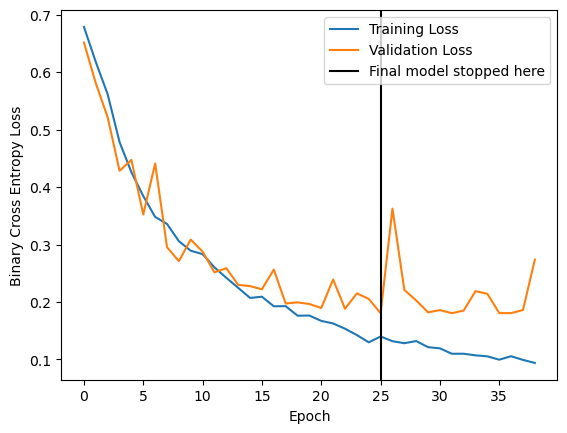

In [12]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)

plt.plot(np.arange(len(Training_losses)),Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses)),Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()


In [13]:
# Analyze the test dataset using the final model

# Define test epoch loop
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Reshape Labels and convert to float
            y = torch.reshape(y,(len(y),1))
            y = y.to(torch.float32)
                        
            pred = model(X)
            
            test_predictions += torch.flatten(pred.cpu()).tolist()
            test_labels += torch.flatten(y.cpu()).tolist()
            
    return(test_predictions, test_labels)
    
test_predictions , test_labels = test(test_dataloader, final_model)


AUROC: 0.9808


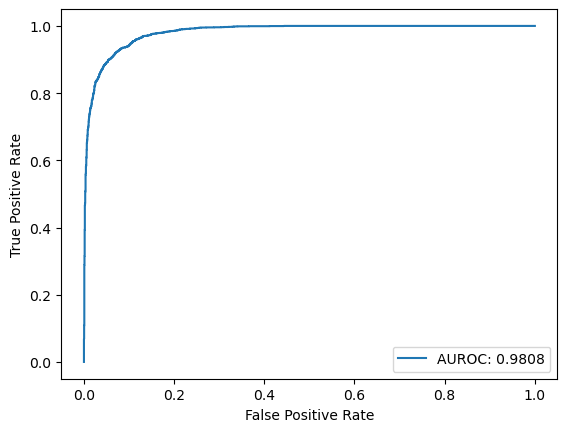

In [14]:
# Plot ROC and compute AUROC


fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, test_predictions, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'AUROC: {auc_test:0.4f}')

plt.plot(fpr, tpr, label=f'AUROC: {auc_test:0.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [15]:
# Compute accuracy as fraction of correct predictions (threshold = 0.5)
Acc = np.sum( ( 1.0*(np.array(test_predictions) > 0.5) ) == np.array(test_labels) ) / len(test_labels)

print("Model accuracy: ", Acc)

Model accuracy:  0.9218


# Save the Model

In [16]:
torch.save(final_model.state_dict(), "HW2_convnet_model.pth")
print("Saved PyTorch Model State to HW2_convnet_model.pth")

Saved PyTorch Model State to HW2_convnet_model.pth


# Quick remarks

The main limitation with this model is overfitting. To avoid over fitting I used a larger dataset, several convolutional layers, and I applied random rotations / flips to the training data.

It is possible that resizing hindered the performance of the model. It lead to loss of information and changed the aspect ratio of the images.

Finally, hyperparameters and model architecture were tuned (to minimize validation loss) by-hand, a more robust optimization could also improve performance.